In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

import hmm_utils
from hmm import HMMRecalibration
import stabilizer_utils

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


min_nblocks    = 2
participant    = 'T5'


FILE_DIR       = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/' + participant + '/'
fig_path       = '/home/users/ghwilson/projects/nonstationarities/figures/'
filelist       = glob.glob(FILE_DIR + 'historical/*')
filelist.extend(glob.glob(FILE_DIR + 'new/*'))

block_constraints = getBlockConstraints(FILE_DIR)
files             = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)

### train linear regression on day 0, get baseline performance measure


In [2]:
# general settings:
ref_idx    = 1
new_idx    = 5
train_size = 0.67
sigma      = 2
task       = None

# recalibration settings:
hmm_cfg  = {'gridSize' : 20, 'stayProb' : 0.999, 'vmKappa' : 2, 'inflection' : 70, 'exp' : 0.5, 'probThreshold' : 'probWeighted'}
stab_cfg = {'model_type' : 'FactorAnalysis', 'n_components' : 6, 'B' : 160, 'thresh' : 0.01}

In [3]:
# Get initial day performance and decoder:
fields     = ['TX', 'cursorPos', 'targetPos']


ref_file    = files[ref_idx]
day0        = DataStruct(ref_file, alignScreens = True, causal_filter = sigma)
session_dat = getTrainTest(day0, train_size = train_size, task = task, blocks = block_constraints[ref_file], 
                           fields = fields, returnFlattened = True)

ref_train_y     = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
ref_test_y      = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
ref_train_x, ref_test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'blockwise', concatenate = True)

# fit a regular regression model
ref_decoder = LinearRegression(fit_intercept = False).fit(ref_train_x, ref_train_y)
ref_score   = ref_decoder.score(ref_test_x, ref_test_y)

# fit a factor-analysis based model
stab = stabilizer_utils.Stabilizer(model_type = stab_cfg['model_type'], n_components = stab_cfg['n_components'])
stab.fit_ref(ref_train_x)
stab_data  = {'ref_latents' : stab.ref_model.transform(ref_test_x),
              'ref_y' : ref_test_y}

latent_decoder = LinearRegression(fit_intercept = False).fit(stab.ref_model.transform(ref_train_x), ref_train_y)
latent_score   = latent_decoder.score(stab.ref_model.transform(ref_test_x), ref_test_y)

print('Performance on reference day: R^2 = ', ref_score)
print('Performance on reference day w/ latent decoder: R^2 = ', latent_score)

Performance on reference day: R^2 =  0.43060201416462096
Performance on reference day w/ latent decoder: R^2 =  0.38145521028658075


Load new data, fit HMM on noisy outputs from old decoder

In [143]:
# now test on new day

file        = files[new_idx]
new_dat     = DataStruct(file, alignScreens = True, causal_filter = sigma)
blocks      = block_constraints[file]
session_dat = getTrainTest(new_dat, train_size = train_size, task = task, blocks = blocks, fields = fields, returnFlattened = True)

new_train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
new_test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
new_train_x, new_test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], method = 'blockwise', concatenate = True)
new_cursorPos       = np.concatenate(session_dat['train_cursorPos'])
new_targetPos       = np.concatenate(session_dat['train_targetPos'])


# HMM fitting:
nStates         = hmm_cfg['gridSize']**2
stateTrans      = np.eye(nStates) * hmm_cfg['stayProb'] #Define the state transition matrix, which assumes uniform transition probability of transitioning to new state
targLocs        = hmm_utils.get_DiscreteTargetGrid(new_dat, gridSize = hmm_cfg['gridSize'], task = task)

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-hmm_cfg['stayProb'])/(nStates-1)
    
pStateStart = np.zeros((nStates,1)) + (1/nStates)
adjustKappa = lambda dist : 1 / (1 + np.exp(-1 * (dist - hmm_cfg['inflection']) * hmm_cfg['exp']))

hmm         = HMMRecalibration(stateTrans, targLocs, pStateStart, hmm_cfg['vmKappa'], adjustKappa)
rawDecTraj  = ref_decoder.predict(new_train_x)

viterbi_seq, viterbi_prob = hmm.viterbi_search(rawDecTraj, new_cursorPos)
targStates, pTargState    = hmm.decode(rawDecTraj, new_cursorPos)
maxProb                   = np.max(targStates, axis = 0)  # get P(H_i | O_1, ...., O_n)
inferredTargLoc           = targLocs[viterbi_seq.astype(int), :] 

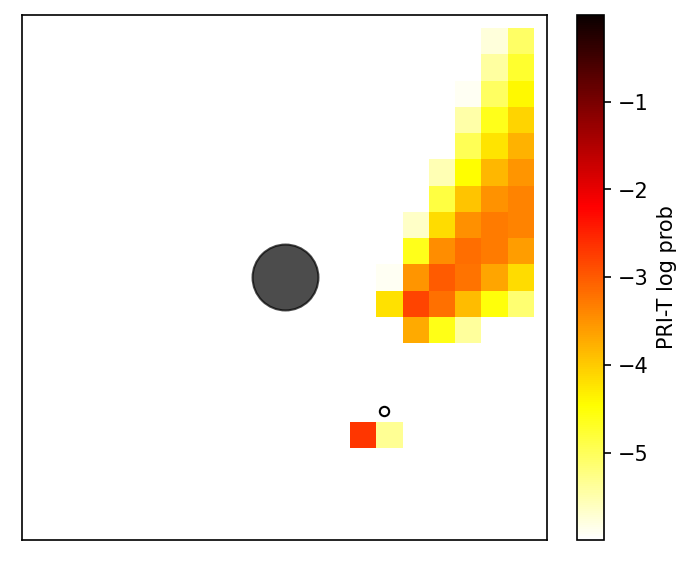

In [168]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

figSize(5, 5)
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
#plt.ioff()
fig = plt.figure()

marker_size = 20
cursor_color = 'white'
target_color = 'k'
cmap         = 'hot_r'
toggle_log   = True



def get_data(t):
    cursor = (new_cursorPos[t, :] - np.min(targLocs, axis = 0)) / (np.max(targLocs, axis = 0) - np.min(targLocs, axis = 0))
    cursor *= 20
    cursor = np.maximum(cursor, 0)
    cursor = np.minimum(cursor, 20)
    
    target = (new_targetPos[t, :] - np.min(targLocs, axis = 0)) / (np.max(targLocs, axis = 0) - np.min(targLocs, axis = 0))
    target *= 20
    target = np.maximum(target, 0)
    target = np.minimum(target, 20)
    
    if toggle_log:
        probs = np.log(targStates[:, t].reshape(20, 20))

    else:
        probs = targStates[:, t].reshape(20, 20)
    
    return cursor, target, probs


cursor, target, probs = get_data(0)


if toggle_log:
    vmin  = np.log(0.0025)
    vmax  = np.log(0.99)
else:
    vmin  = 0
    vmax  = 0.99   

im     = plt.imshow(probs, cmap = cmap, vmin = vmin, vmax = vmax)

targ   = plt.scatter(target[0], target[1], c = target_color, s = marker_size * 50, alpha = 0.7)
curs   = plt.scatter(cursor[0], cursor[1], c = cursor_color, s = marker_size, edgecolors = 'k')

plt.xlim(0, 20)
plt.ylim(0, 20)

ax     = plt.gca()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('PRI-T log prob')

ax.set_yticks([])
ax.set_xticks([])


def animateinit(): #tells our animator what artists will need re-drawing every time
    return [im, targ, curs]

def animate(t):
    idx    = t + 6000
    
    cursor, target, probs = get_data(idx)
    
    #plt.cla()
    im.set_array(probs)

    targ.set_offsets(np.c_[target[0], target[1]])
    curs.set_offsets(np.c_[cursor[0], cursor[1]])


    return [im, targ, curs]


anim = matplotlib.animation.FuncAnimation(fig, animate, init_func = animateinit, 
                                          frames=1000, interval = 20, blit = True)
anim.save('../figures/HMM/PRIT_example.mp4')

Then fit stabilizer on new data

In [ ]:
stab.fit_new(new_train_x, B = stab_cfg['B'], thresh = stab_cfg['thresh'])

stab_data['new_latents'] = stab.ref_model.transform(new_test_x)
stab_data['new_y']       = test_y

stab_data['stabilized_latents'] = stab.transform(new_test_x)
stab_data['stabilized_y']       = new_test_y

In [ ]:
import CosineTuning
from mpl_toolkits import mplot3d

figSize(7, 20)


for i, field in enumerate(['ref', 'stabilized', 'new']):
    displacements = stab_data[field + '_y']
    latents       = stab_data[field + '_latents']
    #latents = firingrate.gaussian_filter1d(latents, axis = 0, sigma = 2, causal=True)
    #displacements = firingrate.gaussian_filter1d(displacements, axis = 0, sigma = 2, causal=True)

    time_idxs = np.where(np.linalg.norm(displacements, axis = 1) > 200)[0]#[1000:7000]
    angles    = CosineTuning.getAngles(displacements[time_idxs])
    coords    = latents[time_idxs, :3]
    
    ax     = plt.subplot(1, 3, i + 1, projection='3d')
    ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], s= 20,
                 c = angles, cmap = 'hsv', alpha = 0.3, rasterized = True)
    ax.view_init(20, 320)  #320

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_zlim([-2, 4])
    
    plt.xlabel('Comp 1')
    plt.ylabel('Comp 2')
    ax.set_zlabel('Comp 3')
    
    r2 = latent_decoder.score(latents, displacements)
    plt.title('R2 = {}'.format(r2))

#plt.savefig(fig_path + 'stabilizer/T5example', format = 'pdf')
plt.show()

In [ ]:
n_channels = 8
window     = np.arange(2000)
_ = plt.plot(window * 0.02, train_x[window, :n_channels] + np.arange(n_channels) * 300, c = 'k')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig(fig_path + 'HMM/T5example_firingrates', format = 'pdf')
plt.show()

In [ ]:
figSize(10, 15)

window = np.arange(8000, 10000) 


plt.subplot(3, 2, 1)
plt.imshow(train_x[window, :].T, aspect = 'auto')

plt.subplot(3, 2, 3)
_ = plt.plot(cursorPos[window, 0], label = 'x pos')
_ = plt.plot(cursorPos[window, 1], label = 'y pos')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()

plt.subplot(3,2, 5)
_ = plt.plot(rawDecTraj[window, 0], label = 'x velocity')
_ = plt.plot(rawDecTraj[window, 1], label = 'y velocity')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()


plt.subplot(3, 2, 2)
_ = plt.plot(targStates[:, window].T)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Time')
plt.ylabel('Probability')

titles = ['Target X-location', 'Target Y-location']
for i in range(2):
    plt.subplot(3, 2, (i * 2) + 4)
    plt.plot((train_y + cursorPos)[window, i], label = 'Actual', c = 'k')
    plt.plot(inferredTargLoc[window, i], label = 'Inferred', zorder = 10)
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('Time')
    plt.legend()
    plt.title(titles[i])
    
#plt.savefig(fig_path + 'HMM/T5example_cursorandneural', format = 'pdf')

plt.tight_layout()
plt.show()

Now test across a series of sessions

In [92]:
import copy
import sweep_utils


# General parameters: 
start_idx     = 1
n_sessions    = 12
sigma         = 2
pairs_folder  = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/session_pairs/'
adan_folder   = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/ADAN/'
# ---------------------------------------------------

scores  = np.zeros((6, n_sessions + 1)) 
dates   = np.empty(n_sessions + 1, dtype = object)
# rows are 0 - mean recalibration; 1 - full recalibration; 
# 2 - stabilizer recalibration; 3 - stabilizer (chained);
# 4- PRIT recalibration (each session), 5 - ADAN recalibration
fields  = ['TX', 'cursorPos', 'targetPos']


# Initialize first day
day0         = DataStruct(files[start_idx], alignScreens = True, causal_filter = sigma)
session_dat  = getTrainTest(day0, train_size = train_size, task = task, blocks = block_constraints[files[start_idx]],
                            fields = fields, returnFlattened = True)

train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
train_x, test_x = get_BlockwiseMeanSubtracted(session_dat['train_TX'], session_dat['test_TX'], concatenate = True)

# All decoders (override stabilizer and ADAN with their own values later)
ref_decoder   = LinearRegression(fit_intercept = False, normalize = False).fit(train_x, train_y)
scores[:, 0]  = ref_decoder.score(test_x, test_y)
dates[0]      = day0.date

# stabilizer
stab = stabilizer_utils.Stabilizer(model_type = stab_cfg['model_type'], n_components = stab_cfg['n_components'])
stab.fit_ref(train_x)
stab_daisychained = copy.deepcopy(stab)
latent_decoder = LinearRegression(fit_intercept = False, normalize = False).fit(stab.ref_model.transform(train_x), train_y)
scores[3, 0]   = latent_decoder.score(stab.ref_model.transform(test_x), test_y)

# ADAN
scores_file  = os.path.join(adan_folder, 'models/scores', f'scores_{start_idx}.npy')
scores[5, 0] = np.load(scores_file)[0][0]
adan_files   = glob.glob(os.path.join(adan_folder, 'test', '*'))
adan_scores  = sweep_utils.getSummaryDataFrame(adan_files, ['R2_score', 'file', 'days_apart'], prune = None)


models        = list()
hmm_new_ref   = deepcopy(ref_decoder)
for i, file_idx in enumerate(range(start_idx + 1, start_idx + 1 + n_sessions)):
    
    new_date  = re.search(r'(\d+.\d+.\d+.mat)', files[file_idx]).group(0).split('.mat')[0]
    pair_file = glob.glob(os.path.join(pairs_folder, f'{day0.date}_to_{new_date}.npy'))[0]
    pair_data = np.load(pair_file, allow_pickle = True).item()
    dates[i+1] = new_date
    
    train_x = pair_data['B_train_neural']
    test_x  = pair_data['B_test_neural']
    train_y = pair_data['B_train_targvec']
    test_y  = pair_data['B_test_targvec']
    cursorPos = pair_data['B_train_cursor']
        
    # fit stabilizers to new day
    stab.fit_new(train_x, B = stab_cfg['B'], thresh = stab_cfg['thresh'])
    stab_daisychained.fit_new(train_x, B = stab_cfg['B'], thresh = stab_cfg['thresh'], daisy_chain = True)
    
    test_latent              = stab.transform(test_x)
    test_latent_daisychained = stab_daisychained.transform(test_x)
    
    # apply PRIT to new day
    hmm_new_ref  = hmm.recalibrate(hmm_new_ref, [train_x], [cursorPos], probThreshold = hmm_cfg['probThreshold'])

    scores[0, i+1] = ref_decoder.score(test_x, test_y)                                               # mean recalibration
    scores[1, i+1] = LinearRegression(normalize = False).fit(train_x, train_y).score(test_x, test_y) # full recalibration
    
    scores[2, i+1] = latent_decoder.score(test_latent, test_y)
    scores[3, i+1] = latent_decoder.score(test_latent_daisychained, test_y)
    scores[4, i+1] = hmm_new_ref.score(test_x, test_y)
    scores[5, i+1] = adan_scores[adan_scores['file'] == pair_file]['R2_score']
   
    print(new_date, ' finished')

/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in ve

2016.10.03  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.10.05  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.10.07  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.10.10  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.10.12  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.10.13  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.10.17  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.10.19  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.10.24  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.10.26  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.10.31  finished


/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


2016.12.06  finished


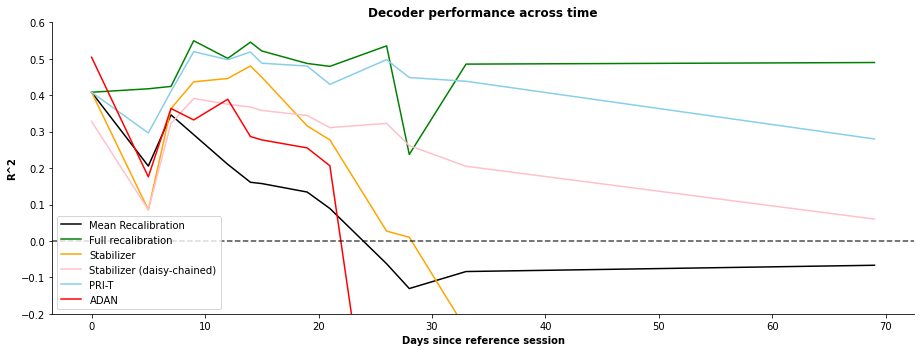

In [95]:
from preprocess import daysBetween
figSize(5, 25)

days = [daysBetween(dates[0], dates[i]) for i in range(len(dates))]

plt.subplot(1, 2, 1)
labels = ['Mean Recalibration', 'Full recalibration', 'Stabilizer', 
          'Stabilizer (daisy-chained)', 'PRI-T', 'ADAN']
colors = ['black', 'green', 'orange', 'pink', 'skyblue', 'r']

for i in range(6):
    plt.plot(days, scores[i, :].T, label = labels[i], color = colors[i])

plt.ylim([-0.2, 0.6]) 
plt.xlabel('Days since reference session', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
plt.axhline(0, color = 'k', linestyle = '--', alpha  = 0.7)
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(fig_path + 'HMM/T5example_HMM_and_stab_stretch', format = 'pdf')
plt.show()